In [480]:
from glob import glob
import re
import math
import os
import gc
import cv2

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow_hub as hub
%matplotlib inline

L = 16000
legal_labels = 'silence bed bird cat dog down eight five four go happy house left marvin nine no off on one right seven sheila six stop three tree two up wow yes zero'.split()
#legal_labels = 'yes no up down left right on off stop go silence unknown'.split()
#src folders
root_path = './mfcc'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'train')
test_data_path = os.path.join(root_path, 'test')

In [481]:
def list_wavs_fname(dirpath, ext='png'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [482]:
def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.Series(nlabels)

In [483]:
labels, fnames = list_wavs_fname(train_data_path)
# print(fnames)

./mfcc/train


In [484]:
new_sample_rate = 8000
y_train = []
x_train = []
# a = cv2.imread(os.path.join(train_data_path, labels[0], fnames[0]))

for label, fname in zip(labels, fnames):
        x_train.append(cv2.resize(cv2.imread(os.path.join(train_data_path, label, fname)), dsize=(28,28), interpolation=cv2.INTER_NEAREST))
        y_train.append(label)
x_train = np.array(x_train)
y_train = label_transform(y_train)
# label_index = y_train.columns.values
# y_train = y_train.values
# y_train = np.array(y_train)
del labels, fnames
gc.collect()
print(x_train)


[[[[140 144  32]
   [140 144  32]
   [140 144  32]
   ...
   [142 125  39]
   [142 125  39]
   [142 125  39]]

  [[140 144  32]
   [140 144  32]
   [140 144  32]
   ...
   [142 125  39]
   [142 125  39]
   [142 125  39]]

  [[140 145  32]
   [140 145  32]
   [140 145  32]
   ...
   [141 131  37]
   [141 131  37]
   [141 131  37]]

  ...

  [[138 153  30]
   [138 153  30]
   [138 153  30]
   ...
   [139 147  31]
   [139 147  31]
   [139 147  31]]

  [[138 153  30]
   [138 153  30]
   [138 153  30]
   ...
   [138 153  30]
   [138 153  30]
   [138 153  30]]

  [[138 153  30]
   [138 153  30]
   [138 153  30]
   ...
   [136 157  30]
   [136 157  30]
   [136 157  30]]]


 [[[141 139  34]
   [141 139  34]
   [141 139  34]
   ...
   [133 166  33]
   [133 166  33]
   [133 166  33]]

  [[141 139  34]
   [141 139  34]
   [141 139  34]
   ...
   [133 166  33]
   [133 166  33]
   [133 166  33]]

  [[141 138  34]
   [141 138  34]
   [141 138  34]
   ...
   [141 131  37]
   [141 131  37]
   [141 131

In [485]:
labels_dict = {}
i = 0
for k in legal_labels:
    if k == '_background_noise_':
        k = 'silence'
    labels_dict[k] = i
    i += 1
print(labels_dict)

{'cat': 3, 'six': 22, 'nine': 14, 'tree': 25, 'right': 19, 'house': 11, 'four': 8, 'two': 26, 'stop': 23, 'go': 9, 'zero': 30, 'seven': 20, 'bed': 1, 'left': 12, 'one': 18, 'silence': 0, 'sheila': 21, 'no': 15, 'up': 27, 'down': 5, 'happy': 10, 'bird': 2, 'yes': 29, 'three': 24, 'eight': 6, 'on': 17, 'off': 16, 'dog': 4, 'marvin': 13, 'wow': 28, 'five': 7}


In [486]:
print(y_train)
#labels_dict = {"yes":0, "no":1, "up":2, "down":3, "left":4, "right":5, "on":6, "off":7, "stop":8, "go":9, "silence":10, "unknown":11}
for i, elem in enumerate(y_train):
    y_train[i] = labels_dict[y_train[i]]
y_train = np.array(y_train).astype(int)
print(y_train.astype(int))

0        tree
1        tree
2        tree
3        tree
4        tree
5        tree
6        tree
7        tree
8        tree
9        tree
10       tree
11       tree
12       tree
13       tree
14       tree
15       tree
16       tree
17       tree
18       tree
19       tree
20       tree
21       tree
22       tree
23       tree
24       tree
25       tree
26       tree
27       tree
28       tree
29       tree
         ... 
64793     six
64794     six
64795     six
64796     six
64797     six
64798     six
64799     six
64800     six
64801     six
64802     six
64803     six
64804     six
64805     six
64806     six
64807     six
64808     six
64809     six
64810     six
64811     six
64812     six
64813     six
64814     six
64815     six
64816     six
64817     six
64818     six
64819     six
64820     six
64821     six
64822     six
Length: 64823, dtype: object
[25 25 25 ... 22 22 22]


In [487]:
y = pd.Series(y_train)
y.value_counts()

23    2380
29    2377
20    2377
30    2376
15    2375
27    2375
26    2373
8     2372
9     2372
18    2370
22    2369
19    2367
17    2367
14    2364
5     2359
16    2357
7     2357
24    2356
12    2353
6     2352
11    1750
13    1746
4     1746
28    1745
10    1742
21    1734
3     1733
25    1733
2     1731
1     1713
0      102
dtype: int64

In [488]:
#shuffle the data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

In [489]:
train_data = x_train[:50000,:]
train_labels = y_train[:50000]
print(train_data.shape)
print(train_labels.shape)



(50000, 28, 28, 3)
(50000,)


In [490]:
eval_data = x_train[-14823:,:]
eval_labels = y_train[-14823:]
print(eval_data.shape)
print(eval_labels.shape)
print(pd.Series(eval_labels).value_counts())

(14823, 28, 28, 3)
(14823,)
29    575
15    571
8     566
12    559
7     557
26    553
30    552
24    548
23    547
14    544
16    541
22    538
17    538
5     536
20    532
19    528
27    523
6     521
18    517
9     508
3     406
2     405
28    405
11    399
10    396
21    396
4     394
1     386
13    385
25    373
0      24
dtype: int64


In [491]:
# train_data = train_data.flatten()
# eval_data = eval_data.flatten()
# print(eval_data.shape)
# print(train_data.shape)

In [492]:
train_data = train_data.astype('float32')
eval_data = eval_data.astype('float32')
train_data = np.multiply(train_data, 1.0/255.0)
eval_data = np.multiply(eval_data, 1.0/255.0)

In [493]:
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 31 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [494]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 3])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [495]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [496]:
def train_cnn_classification_model(
    learning_rate,
    steps,
    batch_size,
    train_data,
    train_labels,
    eval_data,
    eval_labels):

        # Build the Estimator
    model = tf.estimator.Estimator(model_fn, model_dir="./Savemodel")

    # Define the input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': train_data}, y=train_labels,
        batch_size=batch_size, num_epochs=None, shuffle=True)

    # Define the input function for evaluating
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': eval_data}, y=eval_labels,
        batch_size=batch_size, shuffle=False)
    
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {'images': train_data},
        batch_size=batch_size,
        shuffle=False)

    predict_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {'images': eval_data},
        batch_size=batch_size,
        shuffle=False)
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    periods = 10
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        model.train(input_fn, steps=steps)

        train_pred = model.predict(predict_input_fn)
        eval_pred = model.predict(predict_eval_input_fn)
        train_pred = np.array([item for item in train_pred])
        eval_pred  = np.array([item for item in eval_pred])


        training_pred_one_hot = tf.keras.utils.to_categorical(train_pred,31)
        validation_pred_one_hot = tf.keras.utils.to_categorical(eval_pred,31)    

        training_log_loss = metrics.log_loss(train_labels, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(eval_labels, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)

    print("Model training finished.")
    # Calculate final predictions (not probabilities, as above).
    final_predictions = model.predict(input_fn=predict_eval_input_fn)
    final_predictions = np.array([item for item in final_predictions])


    accuracy = metrics.accuracy_score(eval_labels, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    return model

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_train_distribute': None, '_tf_random_seed': None, '_task_type': 'worker', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_global_id_in_cluster': 0, '_model_dir': './Savemodel', '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_task_id': 0, '_is_chief': True, '_session_config': None, '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff10ab02668>, '_num_worker_replicas': 1}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./Savemo

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Savemodel/model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2501 into ./Savemodel/model.ckpt.
INFO:tensorflow:step = 2501, loss = 0.726248
INFO:tensorflow:global_step/sec: 9.74535
INFO:tensorflow:step = 2601, loss = 0.702682 (10.263 sec)
INFO:tensorflow:global_step/sec: 9.884
INFO:tensorflow:step = 2701, loss = 0.6340303 (10.117 sec)
INFO:tensorflow:global_step/sec: 9.93211
INFO:tensorflow:step = 2801, loss = 0.8306999 (10.068 sec)
INFO:tensorflow:global_step/sec: 9.99308
INFO:tensorflow:step = 2901, loss = 0.73387307 (10.007 sec)
INFO:tensorflow:Saving checkpoints for 3000 into ./Savemodel/model.ckpt.
INFO:tensorflow:Loss for final step: 0.63999385.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Savemodel/model.ck

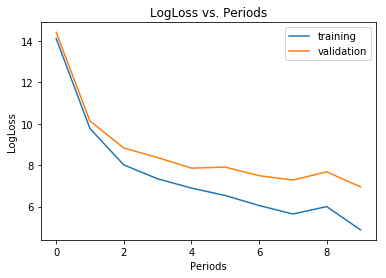

In [497]:
classifier = train_cnn_classification_model(
    learning_rate=.001,
    steps=500,
    batch_size=1000,
    train_data=train_data,
    train_labels=train_labels,
    eval_data=eval_data,
    eval_labels=eval_labels)

In [ ]:
sample_data, sample_labels = parse_labels_and_features(df_sample)
sample_labels = np.asarray(sample_labels, dtype=np.int32)
df_test = np.asarray(df_test, dtype=np.float64)

In [498]:
model = train_cnn_classification_model

# Define the input function for evaluating
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images': df_test},
    y=sample_labels,
    batch_size=batch_size,
    shuffle=False
)

test_predictions = model.predict(test_input_fn)
test_predictions = np.array([item for item in test_predictions])

test_predictions

NameError: name 'df_test' is not defined

In [ ]:
my_submission = pd.DataFrame({'ImageId': df_sample.ImageId, 'Label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('submission6.csv', index=False)